In [1]:
import numpy as np
import pandas as pd
from IPython.display import HTML
import matplotlib.pyplot as plt

from collab2.foraging.toolkit import (
    _add_velocity,
    _generic_velocity_predictor,
    _velocity_predictor_contribution,
    animate_predictors,
    dataObject,
    generate_local_windows,
    generate_pairwiseCopying,
    plot_predictor,
    rescale_to_grid,
    subsample_frames_constant_frame_rate,
    _generate_distance_to_next_pos
)

original_frames: 18739
original_shape: (74956, 5)
resulting_frames: 313
resulting_shape: (1252, 5)
new frame-rate =  2.02


/Users/Admin/Repositories/collab-creatures/collab2/foraging/toolkit/utils.py:36: UserWarning:  Nan values in data.
                Specify handling of missing data using `skip_incomplete_frames` argument to `generate_all_predictors`
  warnings.warn(


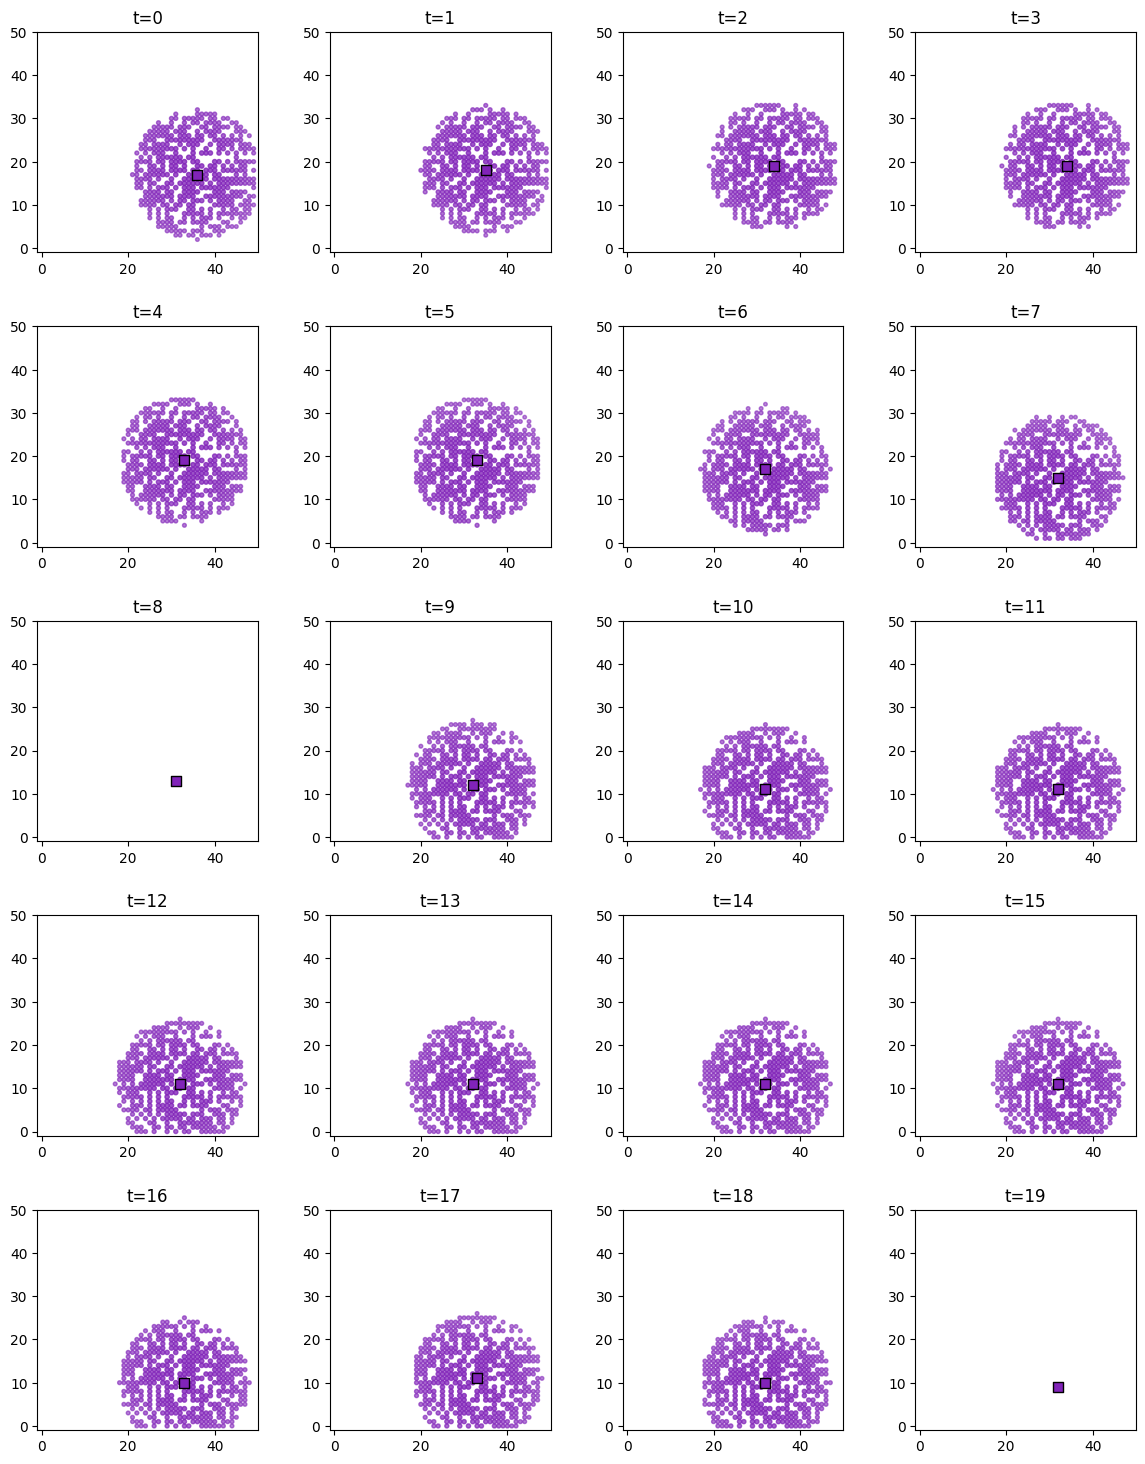

In [2]:
# load data
fish_data = pd.read_csv("4wpf_test.csv")
gridMin = 0
gridMax = 300
grid_size = 50
fps = 121

# scaling and subsampling
fishDF_scaled = rescale_to_grid(
    fish_data, size=grid_size, gridMin=gridMin, gridMax=gridMax
)
fishDF_scaled_subsampled = subsample_frames_constant_frame_rate(
    fishDF_scaled, frame_spacing=60, fps=fps
)

# create a test foragers object with 20 frames
num_frames = 20
foragers_object = dataObject(
    fishDF_scaled_subsampled.loc[fishDF_scaled_subsampled["time"] < 20],
    grid_size=grid_size,
)

# get local windows
local_windows_kwargs = {
    "window_size": 15,
    "sampling_fraction": 0.6,
    "skip_incomplete_frames": True,
}

foragers_object.local_windows_kwargs = local_windows_kwargs

local_windows = generate_local_windows(foragers_object)

# compute distance_to_next_pos 
distance_to_next_pos = _generate_distance_to_next_pos(foragers_object.foragers, local_windows, local_windows_kwargs["window_size"])

# visualize
plot_predictor(
    foragers_object.foragers,
    distance_to_next_pos,
    "scored_distance_to_next_pos",
    [0],
    range(num_frames),
    grid_size,
    size_multiplier=10,
    random_state=99,
)

In [6]:
distance_to_next_pos[0][18]["scored_distance_to_next_pos"].min()

0.7155555555555555